In [1]:
# !wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv
# !curl -O https://lazyprogrammer.me/course_files/sp500_close.csv

In [65]:
import pandas as pd
import numpy as np

In [66]:
df = pd.read_csv('./datasets/airline_passengers.csv', index_col='Month', parse_dates=True)

In [67]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [68]:
df.isna().sum()


Passengers    0
dtype: int64

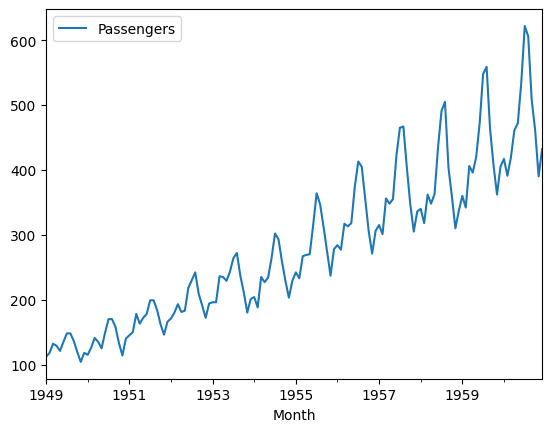

In [69]:
df.plot();

In [77]:
alpha = 0.4# we choose this parameter randomly this is a parameter that can be optimized

In [78]:
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [79]:
df['EWMA'].head()

Month
1949-01-01    112.0000
1949-02-01    114.4000
1949-03-01    121.4400
1949-04-01    124.4640
1949-05-01    123.0784
Name: EWMA, dtype: float64

In [80]:
type(df['Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

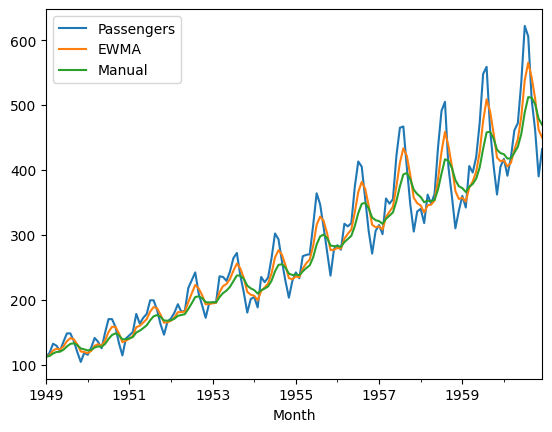

In [81]:
df.plot();

In [82]:
#the process made manually
manual_ewma = []
for x in df['Passengers'].to_numpy():
  if len(manual_ewma) > 0:
    xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
  else:
    xhat = x
  manual_ewma.append(xhat)
df['Manual'] = manual_ewma

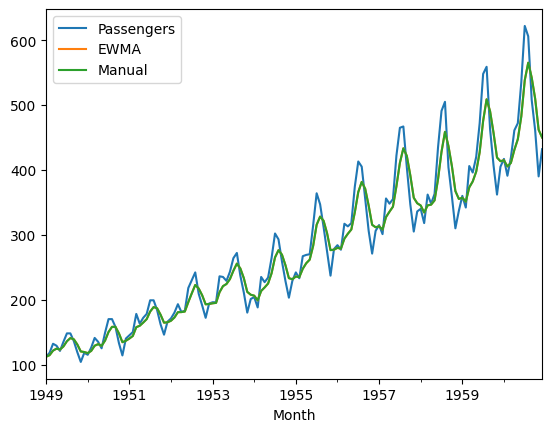

In [83]:
df.plot();

In [85]:
df.head()

,Passengers,EWMA,Manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,114.4000,114.4000
1949-03-01,132,121.4400,121.4400
1949-04-01,129,124.4640,124.4640
1949-05-01,121,123.0784,123.0784


In [86]:
df.drop('Manual', axis=1, inplace=True)

In [16]:
!pip install -U statsmodels

  Using cached patsy-0.5.6-py2.py3-none-any.whl.metadata (3.5 kB)
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB 330.3 kB/s eta 0:00:30
   ---------------------------------------- 0.1/9.8 MB 544.7 kB/s eta 0:00:18
   ---------------------------------------- 0.1/9.8 MB 544.7 kB/s eta 0:00:18
   ---------------------------------------- 0.1/9.8 MB 544.7 kB/s eta 0:00:18
   ---------------------------------------- 0.1/9.8 MB 385.0 kB/s eta 0:00:26
    --------------------------------------- 0.1/9.8 MB 405.9 kB/s eta 0:00:24
    --------------------------------------- 0.1/9.8 MB 405.9 kB/s eta 0:00:24
    --------------------------------------- 0.2/9.8 MB 436.8 kB/s eta 0:00:23
    --------------------------------------- 0.2/9.8 MB 474.7 kB/s eta 0:00:21
   - -------------------------------------- 0.3/9.8 MB 516.0 kB/s eta 0:00:19
   - -----------

In [89]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [90]:
ses = SimpleExpSmoothing(df['Passengers'])

C:\Users\ASUS TUF\.conda\envs\proyecto_machin_learning\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [91]:
# link to offset aliases docs
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [94]:
df.index.freq = 'MS'

In [95]:
ses = SimpleExpSmoothing(
    df['Passengers'],
    initialization_method='legacy-heuristic')

In [96]:
res = ses.fit(smoothing_level=alpha, optimized=False)

In [97]:
res

In [24]:
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [25]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [26]:
np.allclose(df['SES'], res.fittedvalues)

True

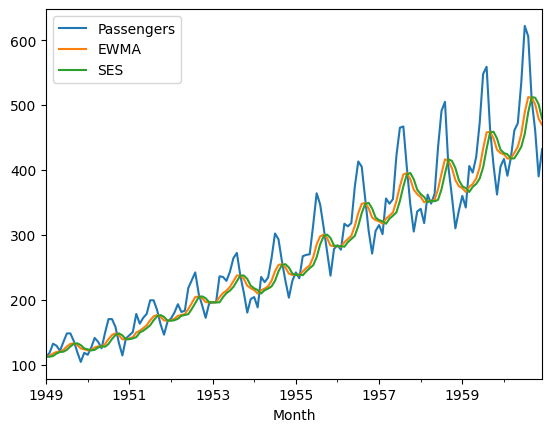

In [27]:
df.plot();


In [28]:
df.head

<bound method NDFrame.head of             Passengers        EWMA         SES
Month                                         
1949-01-01         112  112.000000  112.000000
1949-02-01         118  113.200000  112.000000
1949-03-01         132  116.960000  113.200000
1949-04-01         129  119.368000  116.960000
1949-05-01         121  119.694400  119.368000
...                ...         ...         ...
1960-08-01         606  512.214093  488.767616
1960-09-01         508  511.371274  512.214093
1960-10-01         461  501.297019  511.371274
1960-11-01         390  479.037615  501.297019
1960-12-01         432  469.630092  479.037615

[144 rows x 3 columns]>

In [29]:
df['SES-1'] = df['SES'].shift(-1)

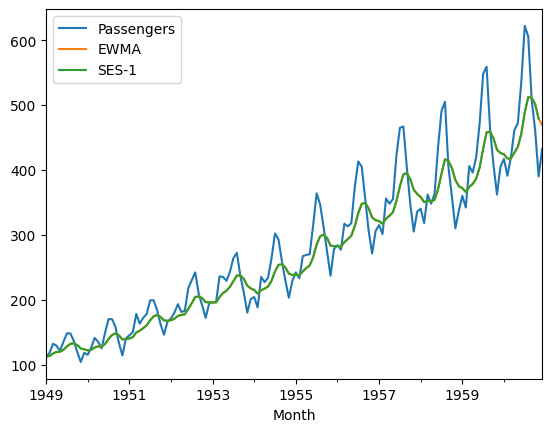

In [30]:
### No!
df[['Passengers', 'EWMA', 'SES-1']].plot();

In [31]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [32]:
ses = SimpleExpSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic')
res = ses.fit()

In [33]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

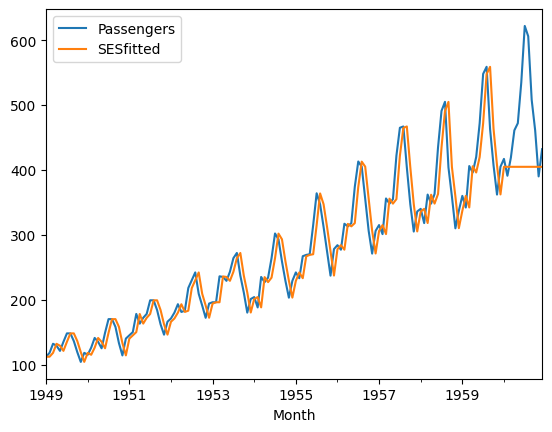

In [34]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
df[['Passengers', 'SESfitted']].plot();

In [35]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [36]:
from statsmodels.tsa.holtwinters import Holt

In [37]:
holt = Holt(
    df['Passengers'],
    initialization_method='legacy-heuristic')

In [38]:
res_h = holt.fit()

In [39]:
df['Holt'] = res_h.fittedvalues

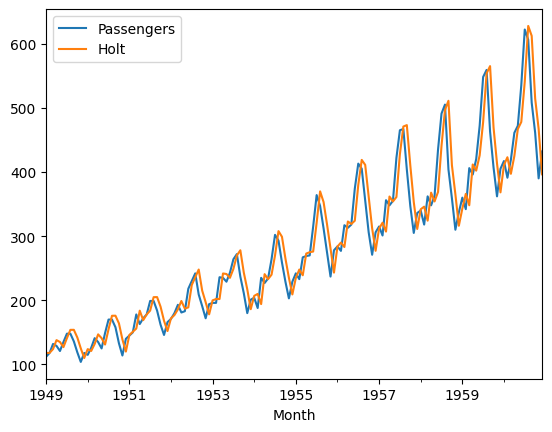

In [40]:
df[['Passengers', 'Holt']].plot();

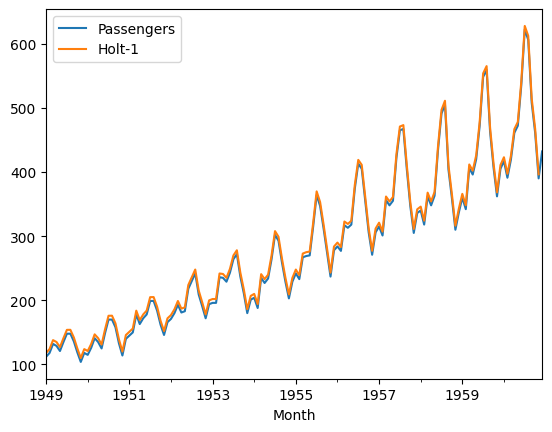

In [41]:
### No!
df['Holt-1'] = df['Holt'].shift(-1)
df[['Passengers', 'Holt-1']].plot();

In [42]:
holt = Holt(train['Passengers'], initialization_method='legacy-heuristic')
res_h = holt.fit()
df.loc[train_idx, 'Holt'] = res_h.fittedvalues

In [43]:
df.loc[test_idx, 'Holt'] = res_h.forecast(N_test)

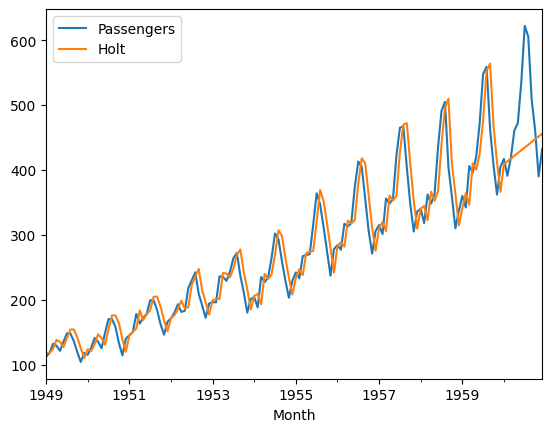

In [44]:
df[['Passengers', 'Holt']].plot();

In [45]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [46]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()

In [47]:
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues

In [48]:
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

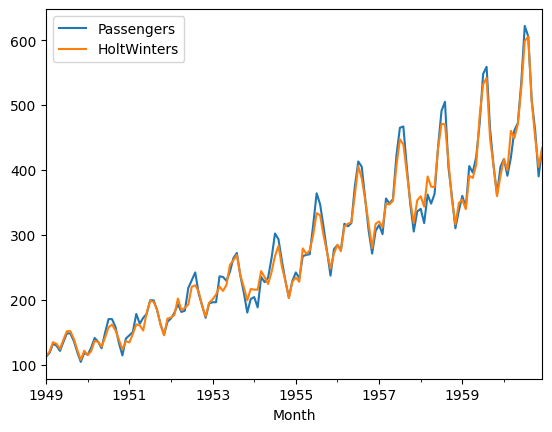

In [49]:
df[['Passengers', 'HoltWinters']].plot();

In [50]:
def rmse(y, t):
  return np.sqrt(np.mean((y - t)**2))

In [51]:
def mae(y, t):
  return np.mean(np.abs(y - t))

In [52]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 11.852990975608384
Test RMSE: 15.543111574921017


In [53]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 8.892129241474121
Test MAE: 10.438273613134896


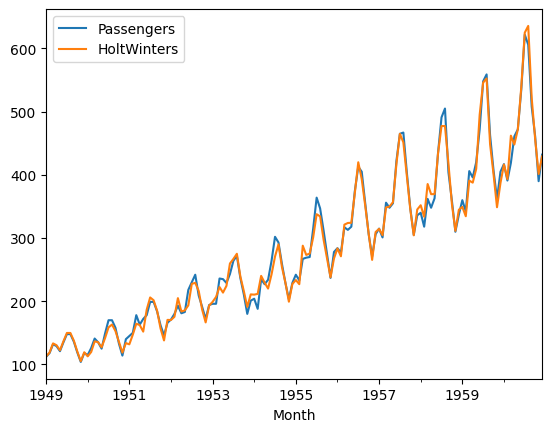

In [54]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [55]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 10.153934838980446
Test RMSE: 16.53521274372282


In [56]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.5520526448052845
Test MAE: 10.68334156323617


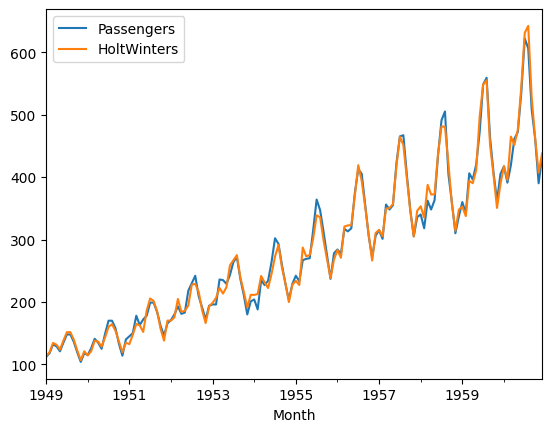

In [57]:
hw = ExponentialSmoothing(
    train['Passengers'],
    initialization_method='legacy-heuristic',
    trend='mul', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot();

In [58]:
print("Train RMSE:", rmse(train['Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.887178133859093
Test RMSE: 19.102093666490106


In [59]:
print("Train MAE:", mae(train['Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.408706879667877
Test MAE: 13.450514902523045
